In [1]:
# https://blog.csdn.net/s09094031/article/details/92428209?app_version=6.3.1&csdn_share_tail=%7B%22type%22%3A%22blog%22%2C%22rType%22%3A%22article%22%2C%22rId%22%3A%2292428209%22%2C%22source%22%3A%22unlogin%22%7D&utm_source=app

# Adding Count Encoding features for String, Boolean, Categorical features
  
<div class="alert alert-block alert-warning" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp; My idea here was to add Count Encoding of data(pl.String, pl.Boolean, pl.Categorical)
</div>

<div class="alert alert-block alert-warning" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp; Next Idea : Treating Imbalanced Data (like SMOTE...?)
</div>


In [2]:
import sys
from pathlib import Path
import subprocess
import os
import gc
from glob import glob

import numpy as np
import pandas as pd
import polars as pl
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

ROOT = '/kaggle/input/home-credit-credit-risk-model-stability'

In [3]:
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

In [4]:
class Pipeline:

    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df

    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))  #!!?
                df = df.with_columns(pl.col(col).dt.total_days()) # t - t-1
        df = df.drop("date_decision", "MONTH")
        return df

    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.95:
                    df = df.drop(col)
        
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()
                if (freq == 1) | (freq > 200):
                    df = df.drop(col)
        
        return df

In [5]:

class Aggregator:
    #Please add or subtract features yourself, be aware that too many features will take up too much space.
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        expr_var = [pl.var(col).alias(f"var_{col}") for col in cols]

        return expr_max +expr_last+expr_mean+expr_var
    
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return  expr_max +expr_last+expr_mean
    
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        #expr_count = [pl.count(col).alias(f"count_{col}") for col in cols]
        return  expr_max +expr_last#+expr_count
    
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols] 
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

In [6]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    if depth in [1,2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df)) 
    return df

def read_files(regex_path, depth=None):
    chunks = []
    
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        chunks.append(df)
    
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    return df

In [7]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base

In [8]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    return df_data, cat_cols

In [9]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [10]:
def reduce_group(grps, df):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = df[gg].nunique()
            if n>mx:
                mx = n
                vx = gg
            #print(str(gg)+'-'+str(n),', ',end='')
        use.append(vx)
        #print()
    print('Use these',use)
    return use

def group_columns_by_correlation(matrix, threshold=0.8):
    # 计算列之间的相关性
    correlation_matrix = matrix.corr()

    # 分组列
    groups = []
    remaining_cols = list(matrix.columns)
    while remaining_cols:
        col = remaining_cols.pop(0)
        group = [col]
        correlated_cols = [col]
        for c in remaining_cols:
            if correlation_matrix.loc[col, c] >= threshold:
                group.append(c)
                correlated_cols.append(c)
        groups.append(group)
        remaining_cols = [c for c in remaining_cols if c not in correlated_cols]
    
    return groups

In [11]:
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")

TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

In [12]:
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
        read_file(TRAIN_DIR / "train_applprev_2.parquet", 2),
        read_file(TRAIN_DIR / "train_person_2.parquet", 2)
    ]
}

In [13]:
df_train = feature_eng(**data_store)
print("train data shape:\t", df_train.shape)
del data_store
df_train = df_train.pipe(Pipeline.filter_cols)
gc.collect()

train data shape:	 (1526659, 939)


0

In [14]:
from tqdm.notebook import tqdm
num_cols = df_train.select("^*A$").columns

for col in tqdm(num_cols, total=len(num_cols)):
    df_train = df_train.with_columns(
        pl.col(col).fill_null(0)
    )
df_train

  0%|          | 0/160 [00:00<?, ?it/s]

case_id,WEEK_NUM,target,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,…,last_collaterals_typeofguarante_359M,last_collaterals_typeofguarante_669M,last_subjectroles_name_541M,last_subjectroles_name_838M,max_collater_valueofguarantee_1124L,max_collater_valueofguarantee_876L,max_pmts_month_158T,max_pmts_month_706T,max_pmts_year_1139T,max_pmts_year_507T,last_pmts_month_158T,last_pmts_month_706T,last_pmts_year_1139T,last_pmts_year_507T,max_num_group1_13,max_num_group2_13,last_num_group1_13,last_num_group2_13,max_cacccardblochreas_147M,last_cacccardblochreas_147M,max_conts_type_509L,max_credacc_cards_status_52L,last_conts_type_509L,max_num_group1_14,max_num_group2_14,last_num_group1_14,last_num_group2_14,max_conts_role_79M,max_empls_economicalst_849M,max_empls_employer_name_740M,last_conts_role_79M,last_empls_economicalst_849M,last_empls_employer_name_740M,max_num_group1_15,max_num_group2_15,last_num_group1_15,last_num_group2_15
i64,i64,i64,i8,i8,i64,i64,i64,f64,i64,f64,f64,f64,f64,f64,str,str,str,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,str,i64,i64,i64,f64,f64,f64,f64,…,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,str,str,str,str,str,i64,i64,i64,i64,str,str,str,str,str,str,i64,i64,i64,i64
0,0,0,1,4,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,null,null,null,0.0,null,null,null,null,null,null,null,0.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1,0,0,1,4,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,null,null,null,0.0,null,null,null,null,null,null,null,0.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2,0,0,1,5,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,null,null,null,0.0,null,null,null,null,null,null,null,0.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""PRIMARY_MOBILE…",null,"""EMPLOYMENT_PHO…",1,1,1,1,null,null,null,null,null,null,null,null,null,null
3,0,0,1,4,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,null,null,null,0.0,null,null,null,null,null,null,null,0.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""PRIMARY_MOBILE…",null,"""PRIMARY_EMAIL""",0,2,0,2,null,null,null,null,null,null,null,null,null,null
4,0,1,1,5,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,null,null,null,0.0,null,null,null,null,null,null,null,0.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""PRIMARY_MOBILE…",null,"""HOME_PHONE""",0,1,0,1,null,null,null,null,null,null,null,null,null,null
5,0,0,1,3,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,null,null,null,0.0,null,null,null,null,null,null,null,0.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""PRIMARY_MOBILE…",null,"""PRIMARY_MOBILE…",0,0,0,0,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1"""

In [15]:
encoding_cols = df_train.select(pl.selectors.by_dtype([pl.String, pl.Boolean, pl.Categorical])).columns

for col in encoding_cols:
    df_train = df_train.with_columns(pl.col(col).fill_null('Missing'))


In [16]:

mappings = {}
for col in encoding_cols:
    mappings[col] = df_train.group_by(col).len()

df_train_lazy = df_train.select(mappings.keys()).lazy()
# df_train_lazy = pl.LazyFrame(df_train.select('case_id'))

for col, mapping in tqdm(mappings.items(), total=len(mappings)):
    remapping = {category: count for category, count in mapping.rows()}
    remapping[None] = -2
    expr = pl.col(col).replace(
                remapping,
                default=-1,
            )
    df_train_lazy = df_train_lazy.with_columns(expr.alias(col + '_cnt'))
    del col, mapping, remapping
    gc.collect()

del mappings
transformed_train = df_train_lazy.collect()

df_train = pl.concat([df_train, transformed_train.select("^*cnt$")], how='horizontal')
del transformed_train

gc.collect()


  0%|          | 0/126 [00:00<?, ?it/s]

146

In [17]:
df_train, cat_cols = to_pandas(df_train)
df_train = reduce_mem_usage(df_train)
print("train data shape:\t", df_train.shape)

Memory usage of dataframe is 6984.21 MB
Memory usage after optimization is: 2770.73 MB
Decreased by 60.3%
train data shape:	 (1526659, 711)


In [18]:
nums=df_train.select_dtypes(exclude='category').columns
#df_train=df_train[nums]
nans_df = df_train[nums].isna()
nans_groups={}

for col in tqdm(nums, total=len(nums)):
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

uses=[]
for k,v in tqdm(nans_groups.items(), total=len(nans_groups)):
    if len(v)>1:
            Vs = nans_groups[k]
            #cross_features=list(combinations(Vs, 2))
            #make_corr(Vs)
            grps= group_columns_by_correlation(df_train[Vs], threshold=0.7)
            use=reduce_group(grps, df_train)
            uses=uses+use
            #make_corr(use)
    else:
        uses=uses+v
    print('####### NAN count =',k)
print(uses)
print(len(uses))
uses=uses+list(df_train.select_dtypes(include='category').columns)
print(len(uses))
df_train=df_train[uses]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

Use these ['case_id', 'WEEK_NUM', 'target', 'month_decision', 'weekday_decision', 'pmtaverage_3A', 'pmtaverage_4527227A', 'pmtssum_45A', 'amtinstpaidbefduel24m_4187115A', 'disbursedcredamount_1113A', 'avgoutstandbalancel6m_4187114A', 'applicationcnt_361L', 'applications30d_658L', 'applicationscnt_1086L', 'applicationscnt_464L', 'applicationscnt_867L', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgpmtlast12m_4525200A', 'clientscnt_1022L', 'clientscnt_100L', 'clientscnt_1071L', 'clientscnt_1130L', 'clientscnt_157L', 'clientscnt_257L', 'clientscnt_360L', 'clientscnt_493L', 'clientscnt_533L', 'clientscnt_887L', 'clientscnt_946L', 'currdebtcredtyperange_828A', 'deferredmnthsnum_166L', 'downpmt_116A', 'homephncnt_628L', 'inittransactionamount_650A', 'lastapprcredamount_781A', 'lastrejectcredamount_222A', 'maininc_215A', 'maxannuity_159A', 'maxlnamtstart6m_4525199A', 'maxpmtlast3m_4525190A', 'mobilephncnt_593L', 'numactivecreds_622L', 'numactivecredschannel_414L', 'numactivere

In [19]:
sample = pd.read_csv("/kaggle/input/home-credit-credit-risk-model-stability/sample_submission.csv")
device='cpu'
#n_samples=200000
DRY_RUN = True if sample.shape[0] == 10 else False   
if DRY_RUN:
    device='cpu'
    df_train = df_train.iloc[:1000000]
print(device)

cpu


In [20]:
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
        read_file(TEST_DIR / "test_applprev_2.parquet", 2),
        read_file(TEST_DIR / "test_person_2.parquet", 2)
    ]
}

In [21]:
df_test = feature_eng(**data_store)
print("test data shape:\t", df_test.shape)
del data_store
gc.collect()

test data shape:	 (10, 938)


19

In [22]:
# cnt_encoding_cols = df_test.select(pl.selectors.by_dtype([pl.String, pl.Boolean, pl.Categorical])).columns

mappings = {}
for col in encoding_cols:
    mappings[col] = df_test.group_by(col).len()

df_test_lazy = df_test.select(mappings.keys()).lazy()
# df_test_lazy = pl.LazyFrame(df_test.select('case_id'))

for col, mapping in mappings.items():
    remapping = {category: count for category, count in mapping.rows()}
    remapping[None] = -2
    expr = pl.col(col).replace(
                remapping,
                default=-1,
            )
    df_test_lazy = df_test_lazy.with_columns(expr.alias(col + '_cnt'))
    del col, mapping, remapping
del mappings
transformed_test = df_test_lazy.collect()

df_test = pl.concat([df_test, transformed_test.select("^*cnt$")], how='horizontal')
del transformed_test, encoding_cols

In [23]:

df_test = df_test.select([col for col in df_train.columns if col not in ["target"]])
print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

num_cols = df_test.select("^*A$").columns

for col in tqdm(num_cols, total=len(num_cols)):
    df_test = df_test.with_columns(
        pl.col(col).fill_null(0)
    )
    del col
df_test

df_test, cat_cols = to_pandas(df_test, cat_cols)
df_test = reduce_mem_usage(df_test)

gc.collect()

train data shape:	 (1000000, 481)
test data shape:	 (10, 480)


  0%|          | 0/69 [00:00<?, ?it/s]

Memory usage of dataframe is 0.04 MB
Memory usage after optimization is: 0.02 MB
Decreased by 43.7%


0

### Feature Selection

In [24]:
# drop_list = ['max_empl_employedtotal_800L', 'monthsannuity_845L', 'lastactivateddate_801D', 
#              'max_numberofoverdueinstls_725L', 'requesttype_4525192L', 'max_pmts_year_507T', 
#              'lastrejectcommodtypec_5251769M', 'numinstpaidlate1d_3546852L', 'numinstmatpaidtearly2d_4499204L', 
#              'max_overdueamountmaxdateyear_2T', 'max_overdueamountmaxdateyear_994T', 'twobodfilling_608L', 
#              'maxdpdlast12m_727P', 'numinsttopaygrest_4493213L', 'currdebtcredtyperange_828A', 'maxdpdlast9m_1059P', 
#              'numinstpaid_4499208L', 'applicationscnt_867L', 'numinstlswithoutdpd_562L', 'fourthquarter_440L', 
#              'max_num_group1_6', 'max_safeguarantyflag_411L', 'max_dpdmaxdateyear_896T', 'numinstregularpaid_973L', 
#              'avgdbdtollast24m_4525197P', 'numinstpaidearly5dest_4493211L', 'numinstpaidearly5dobd_4499205L', 
#              'homephncnt_628L', 'max_role_1084L', 'max_remitter_829L', 'numrejects9m_859L', 
#              'numinstlallpaidearly3d_817L', 'numinstpaidearly3dest_4493216L', 'annuitynextmonth_57A', 
#              'numinstregularpaidest_4493210L', 'firstquarter_103L', 'clientscnt_533L', 'maxdpdlast3m_392P', 
#              'sellerplacescnt_216L', 'secondquarter_766L', 'max_periodicityofpmts_1102L', 'numinstlsallpaid_934L', 
#              'opencred_647L', 'numinstls_657L', 'numactivecredschannel_414L', 'numinstpaidearly3d_3546850L', 
#              'numinstpaidearlyest_4493214L', 'max_totaldebtoverduevalue_718A', 'paytype1st_925L', 
#              'max_inittransactioncode_279L', 'max_contractst_545M', 'max_cancelreason_3545846M', 
#              'max_rejectreason_755M', 'max_personindex_1023L', 'max_subjectroles_name_838M', 'maxdpdlast6m_474P', 
#              'max_subjectrole_182M', 'actualdpdtolerance_344P', 'max_num_group1_9', 'max_collaterals_typeofguarante_669M', 
#              'numinstpaidearly_338L', 'clientscnt_887L', 'maritalst_893M', 'max_subjectrole_93M', 'max_type_25L', 
#              'max_refreshdate_3813885D', 'numinstpaidearly5d_1087L', 'max_actualdpd_943P', 'max_description_351M', 
#              'education_88M', 'clientscnt_946L', 'clientscnt12m_3712952L', 'numactiverelcontr_750L', 
#              'max_education_927M', 'applicationscnt_1086L', 'sellerplacecnt_915L', 'max_purposeofcred_426M', 
#              'max_subjectroles_name_541M', 'clientscnt_1022L', 'clientscnt_360L', 'max_totaloutstanddebtvalue_668A', 
#              'applicationscnt_629L', 'max_outstandingamount_354A', 'clientscnt_1071L', 'numactivecreds_622L', 
#              'clientscnt_493L', 'paytype_783L', 'clientscnt6m_3712949L', 'clientscnt_304L', 'max_classificationofcontr_13M', 
#              'numnotactivated_1143L', 'commnoinclast6m_3546845L', 'max_numberofoutstandinstls_520L', 
#              'applicationscnt_464L', 'clientscnt_1130L', 'max_numberofoverdueinstls_834L', 'clientscnt3m_3712950L', 
#              'max_rejectreasonclient_4145042M', 'max_contaddr_smempladdr_334L', 'numpmtchanneldd_318L', 
#              'numcontrs3months_479L', 'max_overdueamount_31A', 'max_collaterals_typeofguarante_359M', 
#              'clientscnt_257L', 'clientscnt_157L', 'applications30d_658L', 'clientscnt_100L', 
#              'max_collater_typofvalofguarant_298M', 'max_pmts_month_706T', 'max_pmts_month_158T', 
#              'mastercontrexist_109L', 'max_collater_typofvalofguarant_407M', 'mastercontrelectronic_519L', 
#              'applicationcnt_361L', 'max_persontype_1072L', 'max_empladdr_district_926M', 'deferredmnthsnum_166L', 
#              'max_empladdr_zipcode_114M', 'max_persontype_792L', 'max_contaddr_matchlist_1032L']

In [25]:
# df_train = df_train.drop(drop_list)
# df_test = df_test.drop(drop_list)

### Handle categorical features (Ordinal encoding)

In [26]:
# cat_list = [col for col in df_train.columns if df_train[col].dtype.name == 'category']

# catfreq_dict = {}
# catcatfreq_dict = {}

# for col in cat_list:
#     catfreq_dict[col] = len(list(df_train[col].value_counts()))
#     catcatfreq_dict[col] = {}
#     for d in dict(df_train[col].value_counts()).items():
#         catcatfreq_dict[col][d[0]] = d[1]

# catfreq_df = pd.DataFrame.from_dict(catfreq_dict, orient='index', columns=['Categories'])
# display(catfreq_df.sort_values(by="Categories", ascending=False).head())
# display(catfreq_df.sort_values(by="Categories", ascending=True).head())

In [27]:
# ordinal_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
# df_train[cat_list] = ordinal_enc.fit_transform(df_train[cat_list])
# df_test[cat_list] = ordinal_enc.transform(df_test[cat_list])
# df_train[cat_list].head()

### Handle NaN

In [28]:
# nan_list = []
# for col, boo in df_train.isnull().any().items():
#     if boo == True:
#         nan_list.append(col)

# print(f"Number of col contains Nan value: {len(nan_list)}")
# for i, v in df_train.isna().sum().items():
#     if v/len(df_train)>0.6:
#         print(f"{i} : \t {round((v/len(df_train))*100)}% Nan ")

In [29]:
# ### trial
# from sklearn.impute import SimpleImputer
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# df_train[nan_list] = imp.fit_transform(df_train[nan_list])
# df_test[nan_list] = imp.transform(df_test[nan_list])

In [30]:
# ## no work (too slow..) 
# ## require dimensionality reduction first & features with high feature impor. 
# imputer = KNNImputer()
# df_train = imputer.fit_transform(df_train)

# Handling Int feature as Categorical 

In [31]:
print('Memory usage of dataframe is {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))

Memory usage of dataframe is 1079.65 MB


In [32]:
convert_cols = ['month_decision', 'weekday_decision']

df_train[convert_cols] = df_train[convert_cols].astype('category')
df_test[convert_cols] = df_test[convert_cols].astype('category')

In [33]:
group_cols = df_train.filter(like='group', axis=1).columns
print(df_train.filter(like='group', axis=1).columns)

df_train[group_cols] = df_train[group_cols].astype('object').astype('category')
df_test[group_cols] = df_test[group_cols].astype('object').astype('category')

Index(['max_num_group1_9', 'max_num_group1', 'last_num_group1',
       'max_num_group2_14', 'max_num_group1_3', 'last_num_group1_3',
       'max_num_group1_4', 'max_num_group1_5', 'last_num_group1_6',
       'max_num_group1_10', 'max_num_group1_11', 'max_num_group1_13',
       'max_num_group2_13', 'last_num_group2_13', 'max_num_group1_15',
       'max_num_group2_15'],
      dtype='object')


In [34]:
print('Memory usage of dataframe is {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))

Memory usage of dataframe is 1067.27 MB


# Training and Submission

## Training

In [35]:
y = df_train["target"]
weeks = df_train["WEEK_NUM"]
df_train= df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
# df_train, y = SMOTE().fit_resample(df_train, y)
cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

In [36]:

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 10,  
    "learning_rate": 0.05,
    "n_estimators": 2000,  
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "reg_alpha": 0.1,
    "reg_lambda": 10,
    "extra_trees":True,
    'num_leaves':64,
    'categorical_feature ': 'auto',
    "device": device, 
    "verbose": -1,
}

fitted_models = []
cv_scores = []


for idx_train, idx_valid in cv.split(df_train, y, groups=weeks):#   Because it takes a long time to divide the data set, 
    X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]# each time the data set is divided, two models are trained to each other twice, which saves time.
    X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set = [(X_valid, y_valid)],
        callbacks = [lgb.early_stopping(100)] )
    fitted_models.append(model)
    y_pred_valid = model.predict_proba(X_valid)[:,1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores.append(auc_score)
    del model, auc_score, y_pred_valid
    gc.collect()
    
print("CV AUC scores: ", cv_scores)
print("Maximum CV AUC score: ", max(cv_scores))

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[866]	valid_0's auc: 0.853951
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1214]	valid_0's auc: 0.854673
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[900]	valid_0's auc: 0.849968
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1094]	valid_0's auc: 0.852231
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1199]	valid_0's auc: 0.849789
CV AUC scores:  [0.8539507468676085, 0.8546728056136552, 0.849968204858129, 0.8522307446059456, 0.8497885081655345]
Maximum CV AUC score:  0.8546728056136552


In [37]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

model = VotingModel(fitted_models)

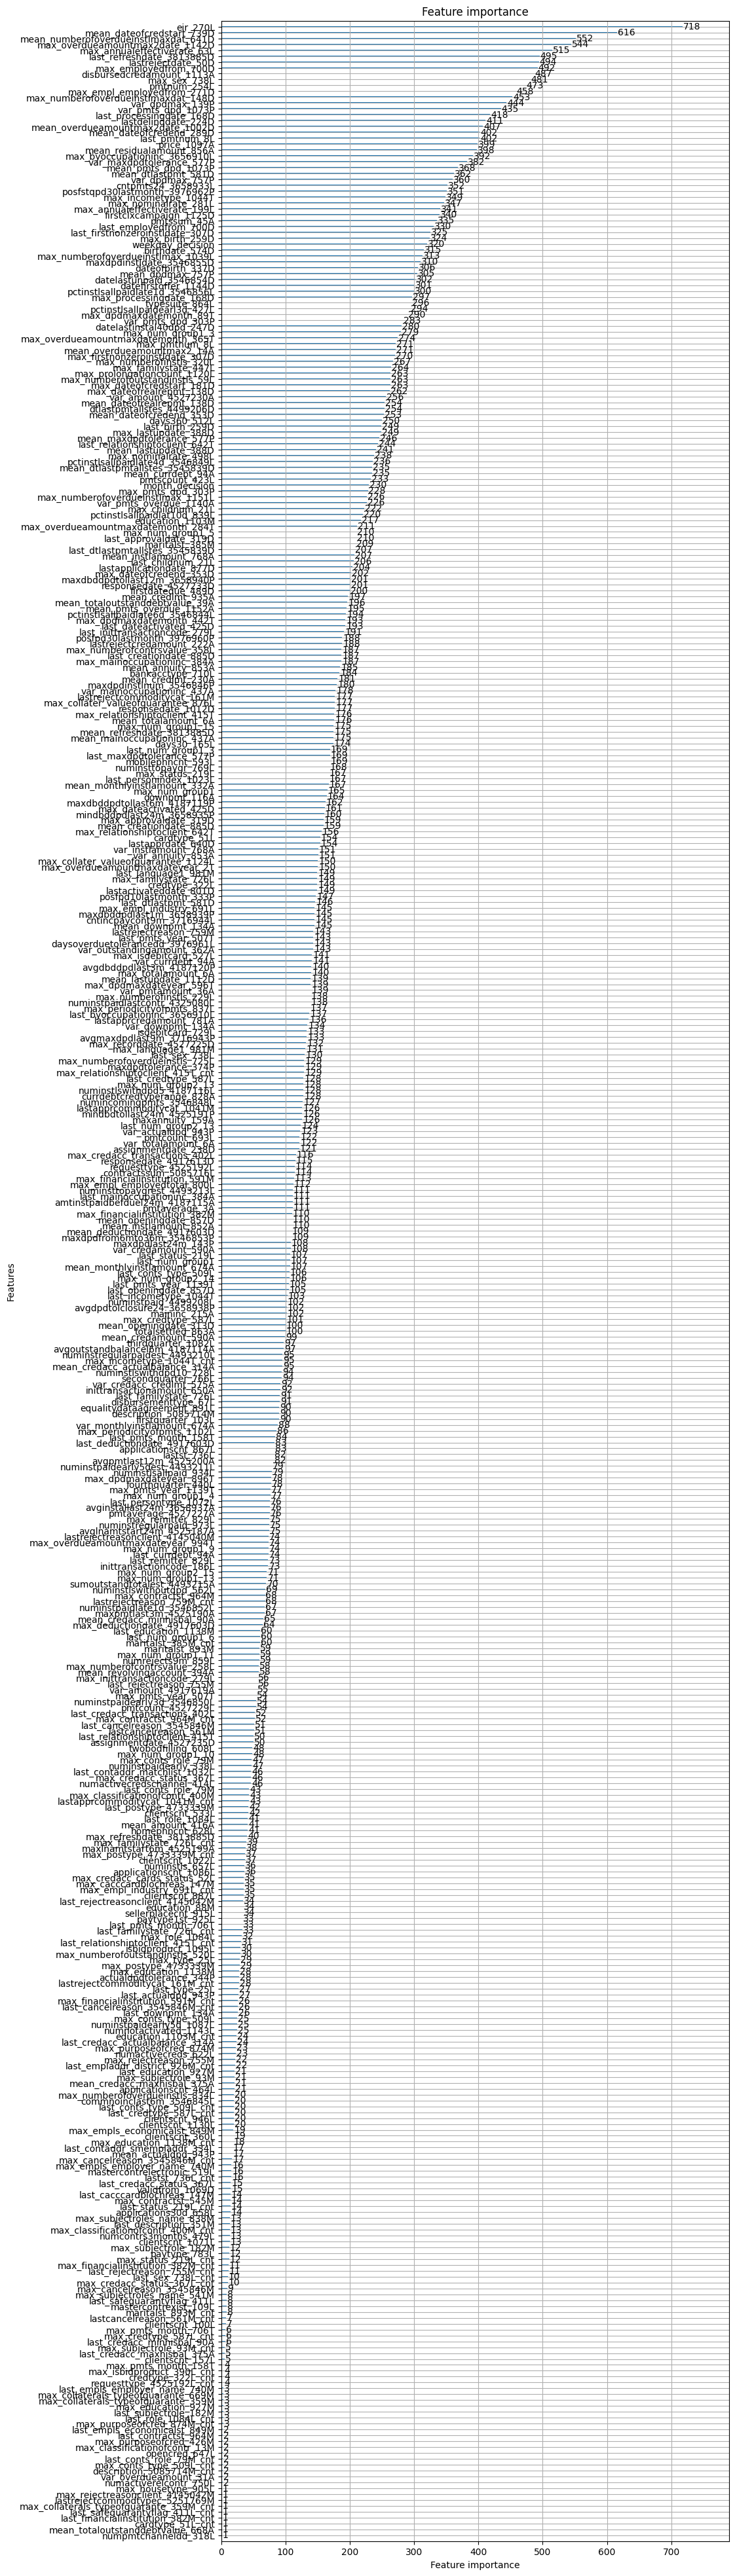

In [38]:
lgb.plot_importance(fitted_models[2], importance_type="split", figsize=(10,50))
plt.show()

In [39]:
features = X_train.columns
importances = fitted_models[2].feature_importances_
feature_importance = pd.DataFrame({'importance':importances,'features':features}).sort_values('importance', ascending=False).reset_index(drop=True)
feature_importance

drop_list = []
for i, f in feature_importance.iterrows():
    if f['importance']<80:
        drop_list.append(f['features'])
print(f"Number of features which are not important: {len(drop_list)} ")

print(drop_list)

Number of features which are not important: 233 
['numinstlsallpaid_934L', 'numinstpaidearly5dest_4493211L', 'fourthquarter_440L', 'max_dpdmaxdateyear_896T', 'max_pmts_year_1139T', 'max_num_group1_4', 'avginstallast24m_3658937A', 'pmtaverage_4527227A', 'last_persontype_1072L', 'max_remitter_829L', 'avglnamtstart24m_4525187A', 'numinstregularpaid_973L', 'max_overdueamountmaxdateyear_994T', 'last_currdebt_94A', 'max_num_group1_9', 'lastrejectreasonclient_4145040M', 'inittransactioncode_186L', 'last_remitter_829L', 'max_num_group1_13', 'max_num_group2_15', 'sumoutstandtotalest_4493215A', 'numinstlswithoutdpd_562L', 'max_contractst_964M', 'lastrejectreason_759M_cnt', 'maxpmtlast3m_4525190A', 'numinstpaidlate1d_3546852L', 'mean_credacc_minhisbal_90A', 'max_deductiondate_4917603D', 'last_num_group1_6', 'maritalst_385M_cnt', 'last_education_1138M', 'max_num_group1_11', 'maritalst_893M', 'numrejects9m_859L', 'max_numberofcontrsvalue_258L', 'mean_revolvingaccount_394A', 'last_rejectreason_755M'

### Submission

In [40]:
df_test = df_test.drop(columns=["WEEK_NUM"])
df_test = df_test.set_index("case_id")


In [41]:
y_pred = pd.Series(model.predict_proba(df_test)[:, 1], index=df_test.index)
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = y_pred
df_subm.to_csv("submission.csv")
df_subm

,score
case_id,
57543,0.025498
57549,0.099303
57551,0.019890
57552,0.099228
57569,0.235050
57630,0.080104
57631,0.117657
57632,0.056211
57633,0.077734


In [42]:
#X_test = df_test.drop(columns=["WEEK_NUM"])
#X_test = X_test.set_index("case_id")

#lgb_pred = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)

#df_subm = pd.read_csv(ROOT / "sample_submission.csv")
#df_subm = df_subm.set_index("case_id")

#df_subm["score"] = lgb_pred

#df_subm.head()

#df_subm.to_csv("submission.csv")

In [43]:
del df_train, df_test
gc.collect()

99411

* handle nan value (both numeric & categorical)
* preprocess the minority categorical value (drop / keep)
* float to int after ordinal encode
* oversampling (smote? (considering date feature)
* high dimension (pca) 
* create new features based on high fea_imp features
...
...

In [44]:
# X_resampled, y_resampled = SMOTE().fit_resample(X, y)